# HW 2
## Problem 2
Find the best predictive model for the below time series using the techniques in the lecture. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.stattools import adfuller
register_matplotlib_converters()
from time import time

In [2]:
# Read data
df_problem2_data = pd.read_csv('EE627A_HW2_Q2.csv', header=None)

In [3]:
# Display first 5 values
df_problem2_data.head()

,0
0,0.8512
1,-2.0698
2,0.8185
3,-1.0678
4,2.3753


In [4]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statisitc: %f' % result[0])
    print('p-value: %f' % result[1])

In [5]:
# Check stationarity
perform_adf_test(df_problem2_data)

ADF Statisitc: -9.878476
p-value: 0.000000


Since p-value is less than 0.05, we can reject the null hypothesis that there is a unit root and can assume that this series is stationary.

Text(0, 0.5, 'Values')

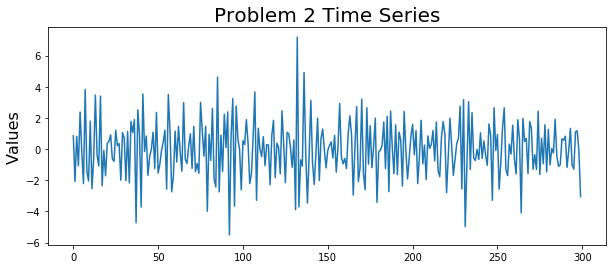

In [6]:
# Plot time series
plt.figure(figsize=(10, 4))

plt.plot(df_problem2_data)

plt.title('Problem 2 Time Series', fontsize=20)
plt.ylabel('Values', fontsize=16)

Just looking at the graph above, we can see the time series is stationary.

### ACF

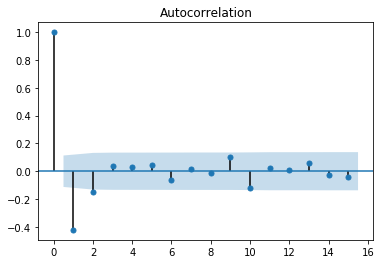

In [7]:
acf_plot = plot_acf(df_problem2_data, lags=15)

For an **AR** model, we expect the **ACF** to exhibit a **diminishing behavior** over time. We do not see that here - instead, we se a couple of strong lags and then the rest are insignificant.

For **MA** models, we observe the ACF plot.

### PACF

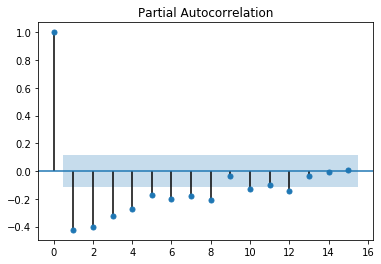

In [8]:
pacf_plot = plot_pacf(df_problem2_data, lags=15)

For an **MA** model, this is the opposite of and AR model. We would expect the **PACF** (and not the ACF) to exhibit a **diminishing behavior** over time, which is what we see here. Therefore, we are liking dealing with a moving average model. 

For **AR** models, we observe the PACF plot.

#### Based on the ACF and PACF, we should start with a Moving Average model with lags 1 and 2.
#### We can also try an Autoregressive model with lags 1, 4, 8, and 12.

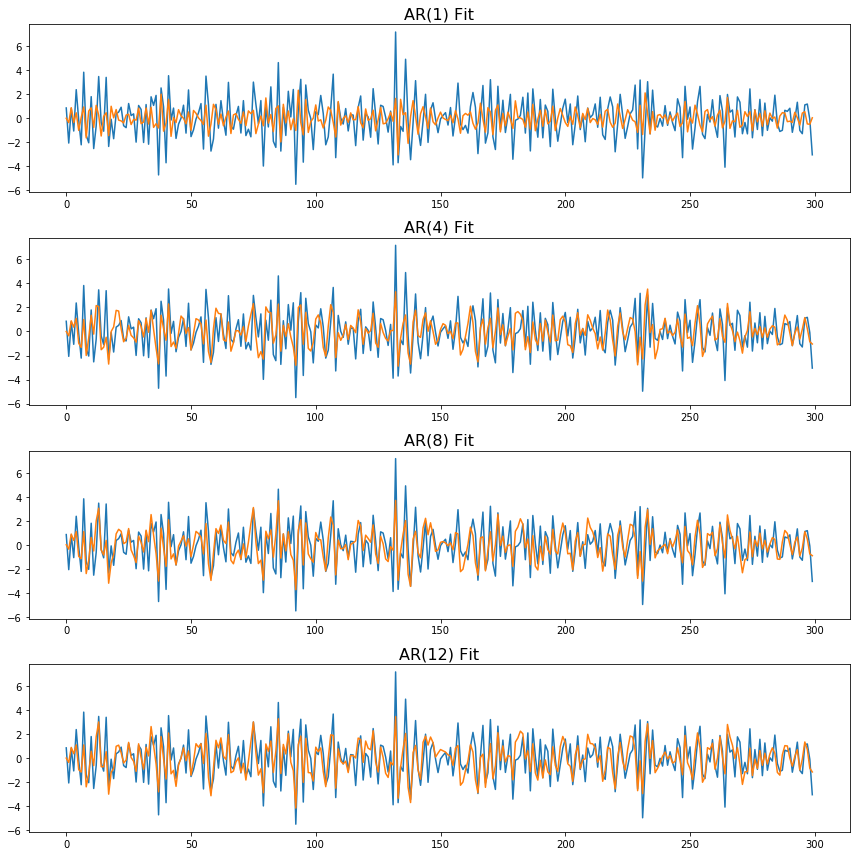

In [9]:
plt.figure(figsize=(12, 12))

ar_orders = [1, 4, 8, 12]
fitted_model_dict = {}

for idx, ar_order in enumerate(ar_orders):
    # Create AR(p) model
    ar_model = ARMA(df_problem2_data, order=(ar_order, 0))
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
    plt.subplot(4, 1, idx + 1)
    plt.plot(df_problem2_data)
    plt.plot(ar_model_fit.fittedvalues)    # fitted values are predicted values from the model
    plt.title('AR(%s) Fit'%ar_order, fontsize=16)

plt.tight_layout()

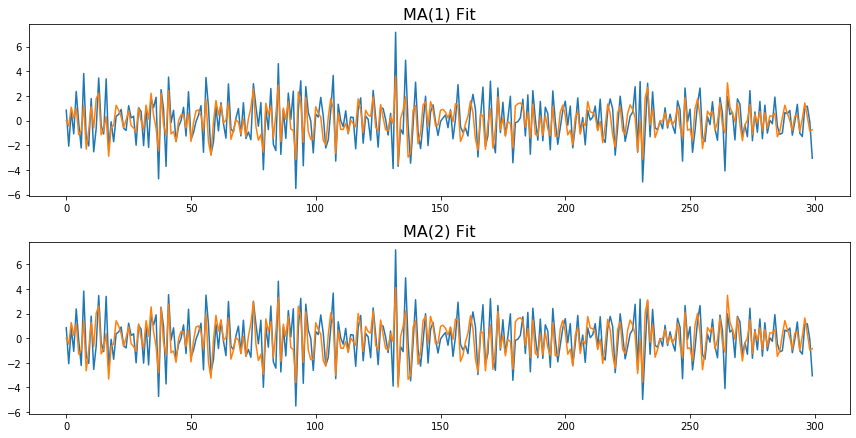

In [10]:
plt.figure(figsize=(12, 12))

ma_orders = [1, 2]
ma_fitted_model_dict = {}

for idx, ma_order in enumerate(ma_orders):
    # Create MA(q) model
    ma_model = ARMA(df_problem2_data, order=(0, ma_order))
    ma_model_fit = ma_model.fit()
    ma_fitted_model_dict[ma_order] = ma_model_fit
    plt.subplot(4, 1, idx + 1)
    plt.plot(df_problem2_data)
    plt.plot(ma_model_fit.fittedvalues)    # fitted values are predicted values from the model
    plt.title('MA(%s) Fit'%ma_order, fontsize=16)

plt.tight_layout()

#### Finally, let's try an ARMA model with the best lags from each (8 from AR and 2 from MA).

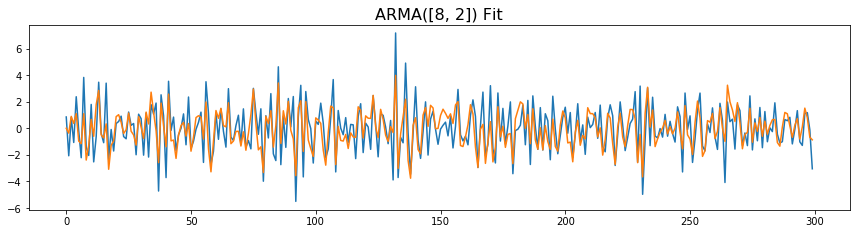

In [11]:
plt.figure(figsize=(12, 12))
arma_order = [8, 2]

# Create ARMA(p,q) model
arma_model = ARMA(df_problem2_data, order=(arma_order[0], arma_order[1]))
arma_model_fit = arma_model.fit()
plt.subplot(4, 1, 1)
plt.plot(df_problem2_data)
plt.plot(arma_model_fit.fittedvalues)    # fitted values are predicted values from the model
plt.title('ARMA(%s) Fit'%arma_order, fontsize=16)

plt.tight_layout()

A good way to check if this model is a good fit is to plot the residuals (difference between raw time series data and fitted model). Then we can plot the ACF and PACF and see if they are equal to zero for all lags.

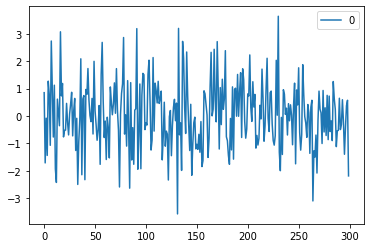

In [12]:
arma_residuals = pd.DataFrame(arma_model_fit.resid)
arma_residuals.plot()
plt.show()

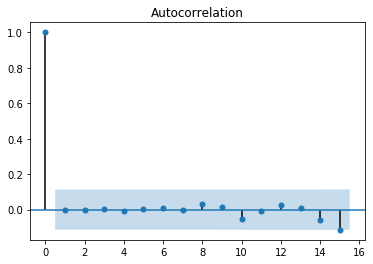

In [13]:
residual_acf_plot = plot_acf(arma_residuals, lags=15)

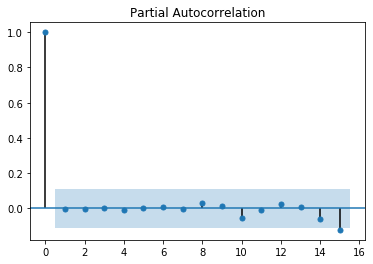

In [14]:
residual_pacf_plot = plot_pacf(arma_residuals, lags=15)

We can see from the ACF and PACF plots above that all the values (except for 15) are around zero, which indicates that this is a pretty good model.

In [15]:
# Summary of model
# print(ar_model_fit.summary())
# print(ma_model_fit.summary())
# print(arma_model_fit.summary())

The above lines produce tables that show a good summary, including data on the importance of each lag chosen to be included in the model. Of note, you want to look at the P>|z| column. Any lags with a value here less than .05 we can consider significant. Any lags over 0.05 are not helping and therefore can be excluded. 

#### AIC and BIC test
Each model has:
- l = a log likelihood (how strong model is a fitting the data)
- k = a number of parameters (order of model plus 1 for constant)
- n = a number of samples used for fitting (for bic)

**AIC = 2k - 2l**

We want model with **lowest AIC** via higher log likelihood or less parameters.

**BIC = ln(n)k - 2l**

We want model with **lowest BIC** via higher log likelihood or less parameters or less samples used in fitting.
This metric is used when comparing models with different numbers of samples.

In [16]:
# AIC Comparison
for ar_order in ar_orders:
    print('AIC for AR(%s): %s'%(ar_order, fitted_model_dict[ar_order].aic))

AIC for AR(1): 1158.7092591158093
AIC for AR(4): 1055.3751538227282
AIC for AR(8): 1016.8582742004178
AIC for AR(12): 1006.4776090034417


In [17]:
for ma_order in ma_orders:
    print('AIC for MA(%s): %s'%(ma_order, ma_fitted_model_dict[ma_order].aic))

AIC for MA(1): 996.3652838172757
AIC for MA(2): 995.4986615228959


In [18]:
print('AIC for ARMA(%s): %s'%(arma_order, arma_model_fit.aic))

AIC for ARMA([8, 2]): 986.9501102640171


### Based on the results for AIC, we can say that an AR(12) model, MA(2) model, or ARMA(8,2) will be best here.